### INDEX

1. 단층, 한 개의 뉴런 RNN 구현, 코드로 뜯어보기.

2. Multiple Neurons RNN Mnist Classification

3. RNN with 다층, 다 RNN

4. LSTM

5. Bonus : Confusion Matrix 

6. 레퍼런스

## 1. 단층, 단뉴런 RNN 구현. 코드 해부 및 텐서 상태 확인 등 전반 이해 제고

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random

In [2]:
def set_seed(seed = 1234):
    '''코드 구현 내용 노트북 내내 재현을 위한 시드 고정.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # 쿠다에서도 시드 고정
    torch.backends.cudnn.deterministic = True
    # 그러하다
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

DEVICE = torch.device("cuda" if USE_CUDA else "cpu")#GPU, CPU
print("다음 기기로 학습합니다:", DEVICE)

Device available now: cuda


위 코드 넣다 뺐다 해보면서 output 비교해보시면 왜 있는지 알게 됩니다.

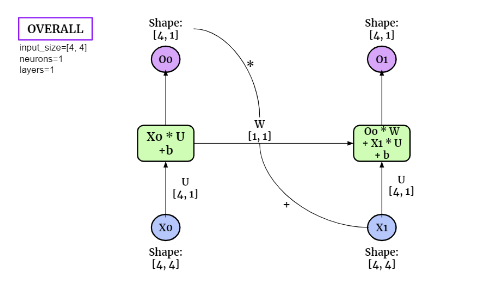

### 1 layer, 1 neuron

In [3]:
n_inputs = 4
n_neurons = 1

In [4]:
input0 = torch.tensor([[0, 1, 2, 0], [3, 4, 5, 0], [6, 7, 8, 0], [9, 0, 1, 0]], dtype = torch.float)
print('input time_0 shape:', input0.shape)


input time_0 shape: torch.Size([4, 4])


In [5]:
input1 = torch.tensor([[9, 8, 7, 0], [3, 4, 5, 0], [6, 7, 8, 0], [9, 0, 1, 0]], dtype = torch.float)
print('input time_1 shape:', input1.shape)

input time_1 shape: torch.Size([4, 4])


레이어 짜기.
이해가 안되면 그림을 보고 다시 이해.

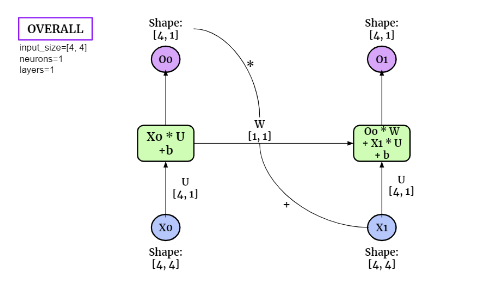

In [6]:
class RNNVanilla(nn.Module):
    
    def __init__(self, n_inputs, n_neurons):
        super(RNNVanilla, self).__init__()
        
        # 초기 랜덤한 weight
        # 현재 시점의 input weight 가진 U 
        self.U = torch.randn(n_inputs, n_neurons) #  n_input * n_neuron
        
        # 이전 시점의 output weight 가진 W
        self.W = torch.randn(n_neurons, n_neurons) # 뉴런 개수에 따른 디멘션 : n_dimension^2
        
        # 편향값 b(ias)
        self.b = torch.zeros(1, n_neurons) # 뉴런 별로 편향 전달 : 1 * 뉴런 크기
    
    # forward: input을 구조에 할당함.
    def forward(self, input0, input1):
        # 0,1에 대한 각각의 아웃풋 도출 코드.
        self.output0 = torch.tanh(torch.mm(input0, self.U) + self.b)
        
        self.output1 = torch.tanh(torch.mm(self.output0, self.W) + torch.mm(input1, self.U) + self.b)
        
        return self.output0, self.output1

In [7]:
RNN_with_one_neuron = RNNVanilla(n_inputs, n_neurons)

output0, output1 = RNN_with_one_neuron(input0, input1)
print('output0:', output0, '\n')
print('output1:', output1)

output0: tensor([[-0.9247],
        [-0.9973],
        [-0.9999],
        [-0.5345]]) 

output1: tensor([[-0.9937],
        [-0.9910],
        [-0.9997],
        [-0.2628]])


In [8]:
print('U:', RNN_with_one_neuron.U)
print('W:', RNN_with_one_neuron.W)
print('bias:', RNN_with_one_neuron.b)

U: tensor([[ 0.0461],
        [ 0.4024],
        [-1.0115],
        [ 0.2167]])
W: tensor([[-0.6123]])
bias: tensor([[0.]])


### 뉴런 개수를 늘려보자!

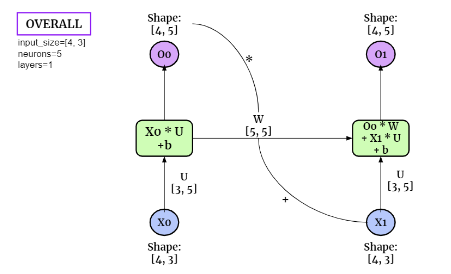

가중치, output에서 텐서 크기가 어떻게 바뀌는지 잘 보는 게 포인트.

In [9]:
n_inputs = 3
n_neurons = 5

In [10]:
input0 = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]], dtype = torch.float)
print('input time_0 shape:', input0.shape)

input1 = torch.tensor([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]], dtype = torch.float)
print('input time_1 shape:', input1.shape)

input time_0 shape: torch.Size([4, 3])
input time_1 shape: torch.Size([4, 3])


In [11]:
# 뉴런 늘어난 모델델
RNN_with_n_neurons = RNNVanilla(n_inputs, n_neurons)

# Checking the output
output0, output1 = RNN_with_n_neurons(input0, input1)
print('output0:', output0, '\n')
print('output1:', output1)

output0: tensor([[ 0.9538, -0.6534,  0.7879, -0.8832, -0.9953],
        [ 1.0000, -0.9287,  0.9998, -1.0000, -0.8423],
        [ 1.0000, -0.9870,  1.0000, -1.0000,  0.5144],
        [ 1.0000,  0.9486,  1.0000, -0.9840,  1.0000]]) 

output1: tensor([[ 1.0000, -0.9795,  1.0000, -1.0000,  1.0000],
        [-0.4268, -0.6269,  0.9398,  0.9575, -0.9623],
        [ 1.0000, -0.9559,  1.0000, -1.0000,  0.9999],
        [ 0.9991,  0.5718,  0.9485, -0.9160,  0.9999]])


In [12]:
# Parameters
print('U:', RNN_with_n_neurons.U)
print('W:', RNN_with_n_neurons.W)
print('bias:', RNN_with_n_neurons.b)

U: tensor([[ 0.5036,  0.2310,  0.6931, -0.2669,  2.1785],
        [ 0.1021, -0.2590, -0.1549, -1.3706, -0.1319],
        [ 0.8848, -0.2611,  0.6104, -0.0098, -1.4473]])
W: tensor([[ 0.7667,  0.0190,  0.0220,  1.1532, -0.3393],
        [ 0.1559,  0.8966, -0.2968, -0.6857,  0.9247],
        [ 0.1825, -0.0737,  0.3147, -1.0369,  0.2100],
        [ 0.6144, -0.0552, -0.3297, -1.7970,  0.8728],
        [ 0.7670, -0.1138, -0.9428,  0.7540,  0.1365]])
bias: tensor([[0., 0., 0., 0., 0.]])


기본적인 RNN 구조와 텐서의 움직임을 파악하셨을 것이라고 생각한다.

### Multiple-Layer Vanila RNN

기본 MNist 데이터셋으로 진행하겠다.

CNN은 이미지 분류에 쓰고 RNN은 번역에 쓴다? 뭐 처음에 연구 목적은 그랬겠지만 RNN도 훌륭한 분류 tool이고, CNN도 훌륭한 시계열 예측 툴로 활용할 수 있다. 너무 이건 여기 쓰는 거! 라는 생각에 매몰되지 말자. 수학적으로 생각하면 둘 다 분류에, 둘 다 예측에 사용할 수 있는 tool임을 기억하자.

In [13]:
# 데이터 트랜스폼 function -> tensor로, 또 normalization, 데이터 증강 등 하는 곳
my_transform = transforms.Compose([transforms.ToTensor()])

In [14]:
mnist_train = torchvision.datasets.MNIST('data', train = True, download=True, transform=my_transform)
mnist_test = torchvision.datasets.MNIST('data', train = False, download=True, transform=my_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



바닐라 RNN 짜보자.

In [15]:
class VanillaRNN_MNIST(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, output_size):
        super(VanillaRNN_MNIST, self).__init__()
        self.batch_size, self.input_size, self.hidden_size, self.output_size = batch_size, input_size, hidden_size, output_size
        
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size)
        # Fully Connected Layer
        self.layer = nn.Linear(hidden_size, self.output_size)
    
    def forward(self, images, prints=False):
        if prints: print('Original Images Shape:', images.shape)
        
        # X,Y,Z -> Y,X,Z
        images = images.permute(1, 0, 2)
        if prints: print('Permuted Imaged Shape:', images.shape)
        
        # 은닉층 0으로 시작
        hidden_state = torch.zeros(1, self.batch_size, self.hidden_size)
        if prints: print('Initial hidden state Shape:', hidden_state.shape)
        
        # Creating RNN
        hidden_outputs, hidden_state = self.rnn(images, hidden_state)
        
        # Log probabilities
        out = self.layer(hidden_state)
        
        if prints:
            print('----hidden_outputs shape:', hidden_outputs.shape, '\n' +
                  '----final hidden state:', hidden_state.shape, '\n' +
                  '----out shape:', out.shape)
        
        # Reshaped out
        out = out.view(-1, self.output_size)
        if prints: print('Out Final Shape:', out.shape)
        
        return out

In [16]:
batch_size = 64        # how many images to be trained in one iteration
input_size = 28        # image 28 by 28
hidden_size = 150      # can be changed to any number: neurons
output_size = 10       # 10 different digits

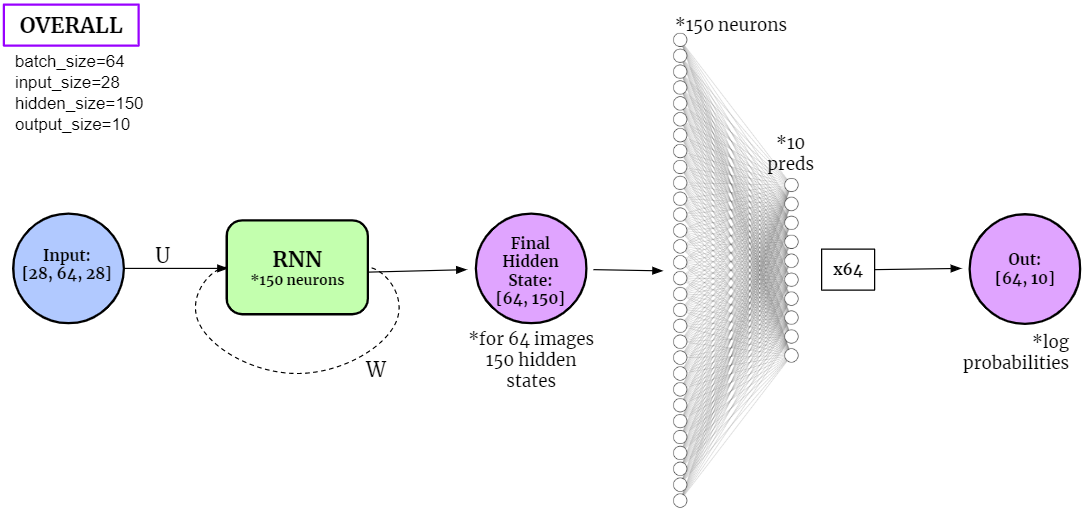

In [17]:
# Create a train_loader to select a batch from it
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)

# Select one full batch from the data
images_example, labels_example = next(iter(train_loader))
print('original images shape:', images_example.shape)

# Reshape
images_example = images_example.view(-1, 28, 28)
print('changed images shape:', images_example.shape)
print('labels shape:', labels_example.shape, '\n')

# Creating the model
model_example = VanillaRNN_MNIST(batch_size, input_size, hidden_size, output_size)


out = model_example(images_example, prints=True)

original images shape: torch.Size([64, 1, 28, 28])
changed images shape: torch.Size([64, 28, 28])
labels shape: torch.Size([64]) 

Original Images Shape: torch.Size([64, 28, 28])
Permuted Imaged Shape: torch.Size([28, 64, 28])
Initial hidden state Shape: torch.Size([1, 64, 150])
----hidden_outputs shape: torch.Size([28, 64, 150]) 
----final hidden state: torch.Size([1, 64, 150]) 
----out shape: torch.Size([1, 64, 10])
Out Final Shape: torch.Size([64, 10])


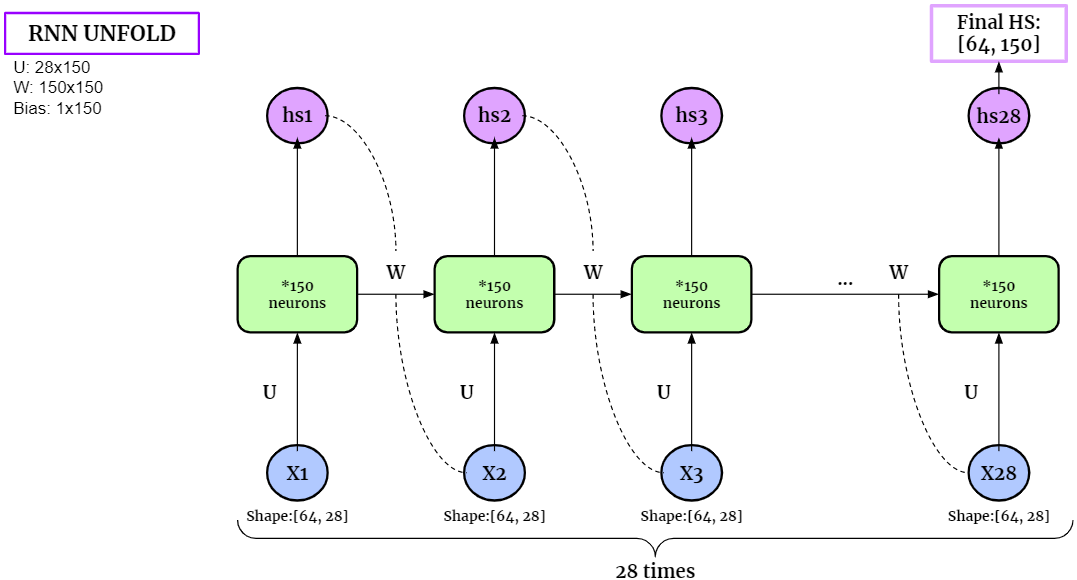

In [18]:
# Understand Model Parameters
print('Len parameters:', len(list(model_example.parameters())), '\n' +
      'Parameters 0 - U:', list(model_example.parameters())[0].shape, '\n' +
      'Parameters 1 - W:', list(model_example.parameters())[1].shape, '\n' +
      'Parameters 2 - Bias:', list(model_example.parameters())[2].shape, '\n' +
      'Parameters 3 - Bias:', list(model_example.parameters())[3].shape, '\n' +
      'Parameters 4 - FNN weights:', list(model_example.parameters())[4].shape, '\n' +
      'Parameters 5 - Predictions:', list(model_example.parameters())[5].shape)

Len parameters: 6 
Parameters 0 - U: torch.Size([150, 28]) 
Parameters 1 - W: torch.Size([150, 150]) 
Parameters 2 - Bias: torch.Size([150]) 
Parameters 3 - Bias: torch.Size([150]) 
Parameters 4 - FNN weights: torch.Size([10, 150]) 
Parameters 5 - Predictions: torch.Size([10])


In [19]:
def get_accuracy(out, actual_labels, batchSize):
    '''배치에서 정확도를 가져온다. log probabilties에서 실제 라벨과 배치 크기 또한 가져온다.'''
    predictions = out.max(dim=1)[1]
    correct = (predictions == actual_labels).sum().item()
    accuracy = correct/batch_size
    
    return accuracy

In [20]:
def train_network(model, train_data, test_data, batchSize=64, num_epochs=1, learning_rate=0.001):
    
    '''모델을 실제로 학습시키는 함수'''
    
    print('Get data ready...')
    # 위에서 배치 하나만 진행함. 여러 배치 수행하기 위해 데이터 로더 맞춰줌
    # Shuffle 트루 해놓으면 1 에폭 끝나고 섞임. 시계열이나 번역 이런거 할 때는 꺼놔야 됩니당
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batchSize, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batchSize, shuffle=True, drop_last=True)
    
    # Create criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    
    print('Training started...')
    # num_epoch 만큼 트레인 수행
    for epoch in range(num_epochs):
        
        # 정확도, 로스 키핑
        train_loss = 0
        train_acc = 0
        
        # 모델 돌리면 됩니다:
        model.train()
        
        for k, (images, labels) in enumerate(train_loader):
            
            # Get rid of the channel
            images = images.view(-1, 28, 28)
            
            # Create log probabilities
            out = model(images)
            # Clears the gradients from previous iteration
            optimizer.zero_grad()
            # Computes loss: how far is the prediction from the actual?
            loss = criterion(out, labels)
            # Computes gradients for neurons
            loss.backward()
            # Updates the weights
            optimizer.step()
            
            # Save Loss & Accuracy after each iteration
            train_loss += loss.item()
            train_acc += get_accuracy(out, labels, batchSize)
            
        
        # Print Average Train Loss & Accuracy after each epoch
        print('TRAIN | Epoch: {}/{} | Loss: {:.2f} | Accuracy: {:.2f}'.format(epoch+1, num_epochs, train_loss/k, train_acc/k))
            
            
    print('Testing Started...')
    # Save Test Accuracy
    test_acc = 0
    # Evaluation mode
    model.eval()
    
    for k, (images, labels) in enumerate(test_loader):
        # Get rid of the channel
        images = images.view(-1, 28, 28)
        
        # Create logit predictions
        out = model(images)
        # Add Accuracy of this batch
        test_acc += get_accuracy(out, labels, batchSize)
        
    # Print Final Test Accuracy
    print('TEST | Average Accuracy per {} Loaders: {:.5f}'.format(k, test_acc/k) )

In [21]:
batch_size=64
input_size=28
hidden_size=150
output_size=10

# Instantiate the model
vanilla_rnn = VanillaRNN_MNIST(batch_size, input_size, hidden_size, output_size)

# ==== TRAIN ====
train_network(vanilla_rnn, mnist_train, mnist_test, num_epochs=10)

Get data ready...
Training started...
TRAIN | Epoch: 1/10 | Loss: 0.86 | Accuracy: 0.71
TRAIN | Epoch: 2/10 | Loss: 0.39 | Accuracy: 0.88
TRAIN | Epoch: 3/10 | Loss: 0.28 | Accuracy: 0.92
TRAIN | Epoch: 4/10 | Loss: 0.23 | Accuracy: 0.94
TRAIN | Epoch: 5/10 | Loss: 0.20 | Accuracy: 0.94
TRAIN | Epoch: 6/10 | Loss: 0.18 | Accuracy: 0.95
TRAIN | Epoch: 7/10 | Loss: 0.16 | Accuracy: 0.96
TRAIN | Epoch: 8/10 | Loss: 0.15 | Accuracy: 0.96
TRAIN | Epoch: 9/10 | Loss: 0.14 | Accuracy: 0.96
TRAIN | Epoch: 10/10 | Loss: 0.13 | Accuracy: 0.96
Testing Started...
TEST | Average Accuracy per 155 Loaders: 0.97167


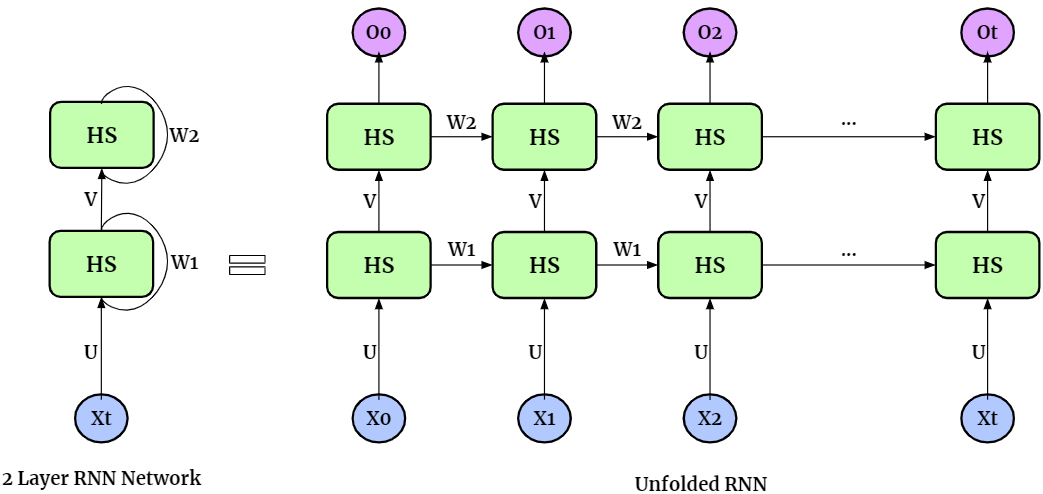

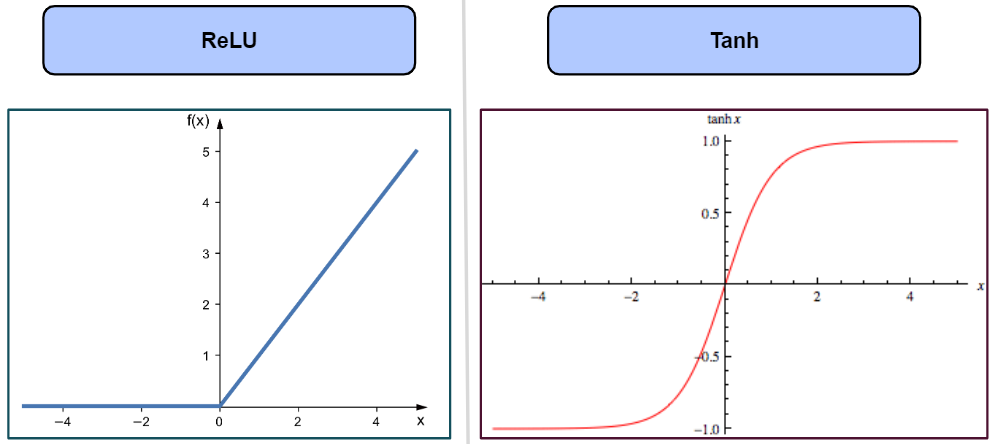

다층레이어로 시도

In [22]:
class MultilayerRNN_MNIST(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size, relu=True):
        super(MultilayerRNN_MNIST, self).__init__()
        self.input_size, self.hidden_size, self.layer_size, self.output_size = input_size, hidden_size, layer_size, output_size
        
        # Create RNN
        if relu:
            self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True, nonlinearity='relu')
        else:
            self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True, nonlinearity='tanh')
            
        # Create FNN
        self.fnn = nn.Linear(hidden_size, output_size)
        
    def forward(self, images, prints=False):
        if prints: print('images shape:', images.shape)
        
        # 시점 0에서 은닉층 시작
        hidden_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size)
        hidden_state = hidden_state.requires_grad_()
        if prints: print('Hidden State shape:', hidden_state.shape)
        
        # Compute RNN
        # 은닉층은 학습될 필요가 없다. detach로 떼줌 참고 : 
        # https://discuss.pytorch.org/t/stupid-question-why-do-you-have-to-detach-the-hidden-state-of-lstms-but-not-the-hidden-state-of-a-linear-network/95089
        output, last_hidden_state = self.rnn(images, hidden_state.detach())
        if prints: print('RNN Output shape:', output.shape, '\n' +
                         'RNN last_hidden_state shape', last_hidden_state.shape)
        
        # Compute FNN
        # We get rid of the second size
        output = self.fnn(output[:, -1, :])
        if prints: print('FNN Output shape:', output.shape)
        
        return output

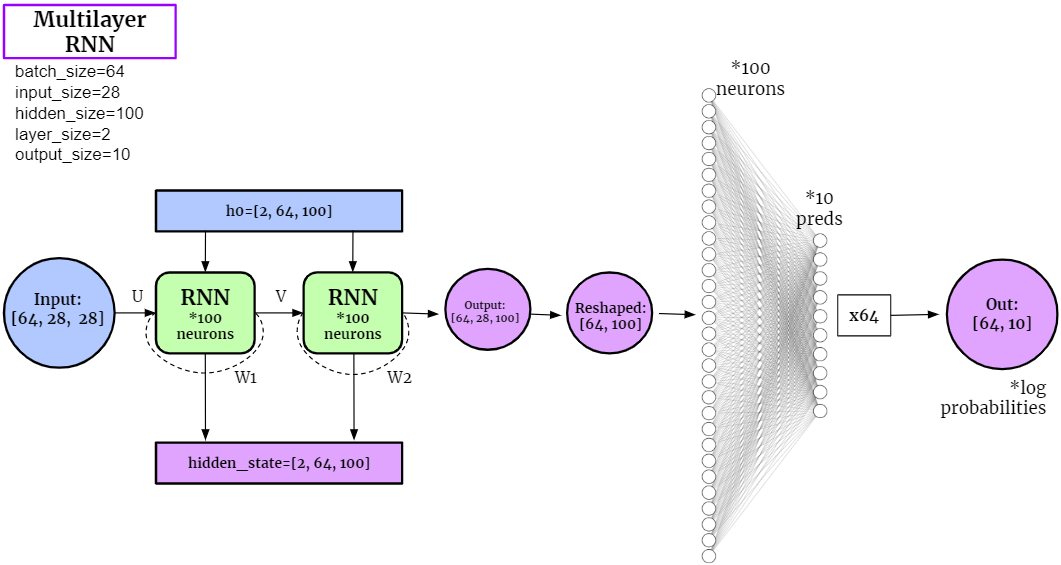

In [24]:
# ===== STATICS =====
batch_size = 64
input_size = 28
hidden_size = 100      # neurons
layer_size = 2         # layers
output_size = 10
# ===================

In [25]:
train_loader_example = torch.utils.data.DataLoader(mnist_train, batch_size=64)

# 배치 하나 가져오기
images, labels = next(iter(train_loader_example))
print('original images shape:', images.shape)

# 배치에서 채널 빼주기
images = images.reshape(-1, 28, 28)
print('reshaped images shape:', images.shape, '\n')

# Create model instance
multilayer_rnn_example = MultilayerRNN_MNIST(input_size, hidden_size, layer_size, output_size, relu=False)
print(multilayer_rnn_example)


# Making log predictions:
out = multilayer_rnn_example(images, prints=True)

original images shape: torch.Size([64, 1, 28, 28])
reshaped images shape: torch.Size([64, 28, 28]) 

MultilayerRNN_MNIST(
  (rnn): RNN(28, 100, num_layers=2, batch_first=True)
  (fnn): Linear(in_features=100, out_features=10, bias=True)
)
images shape: torch.Size([64, 28, 28])
Hidden State shape: torch.Size([2, 64, 100])
RNN Output shape: torch.Size([64, 28, 100]) 
RNN last_hidden_state shape torch.Size([2, 64, 100])
FNN Output shape: torch.Size([64, 10])


In [26]:
# Instantiate the model
# We'll use TANH as our activation function
multilayer_rnn = MultilayerRNN_MNIST(input_size, hidden_size, layer_size, output_size, relu=False)

# ==== TRAIN ====
train_network(multilayer_rnn, mnist_train, mnist_test, num_epochs=10)

Get data ready...
Training started...
TRAIN | Epoch: 1/10 | Loss: 0.67 | Accuracy: 0.78
TRAIN | Epoch: 2/10 | Loss: 0.27 | Accuracy: 0.92
TRAIN | Epoch: 3/10 | Loss: 0.20 | Accuracy: 0.94
TRAIN | Epoch: 4/10 | Loss: 0.16 | Accuracy: 0.96
TRAIN | Epoch: 5/10 | Loss: 0.14 | Accuracy: 0.96
TRAIN | Epoch: 6/10 | Loss: 0.13 | Accuracy: 0.97
TRAIN | Epoch: 7/10 | Loss: 0.12 | Accuracy: 0.97
TRAIN | Epoch: 8/10 | Loss: 0.13 | Accuracy: 0.97
TRAIN | Epoch: 9/10 | Loss: 0.10 | Accuracy: 0.97
TRAIN | Epoch: 10/10 | Loss: 0.10 | Accuracy: 0.97
Testing Started...
TEST | Average Accuracy per 155 Loaders: 0.97147


## LSTM for MNIST Classification

RNN과 구분점 :

1. Cell State와 Gate로 구성 (output이 두 개 : cell, hidden state)

Forget Gate (Xt + ht-1):0에 가까우면 잊고 1에 가까우면 기억

Input Gate (Xt + ht-1): 어떤 정보를 남길 지 후보

Current Cell State: ft * Ct-1 + it * Ct

Output Gate ((Xt + ht-1) * ct): 다음 은닉층에 무엇이 전달될 지 결정

2. 시그모이드 함수를 tanh 대신 사용함.

좀 더 자세한 이해 : https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [27]:
class LSTM_MNIST(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size, bidirectional=True):
        super(LSTM_MNIST, self).__init__()
        
        self.input_size, self.hidden_size, self.layer_size, self.output_size = input_size, hidden_size, layer_size, output_size
        self.bidirectional = bidirectional
        
        # Step1: the LSTM model
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True, bidirectional=bidirectional)
        
        # Step2: the FNN
        if bidirectional: # we'll have 2 more layers
            self.layer = nn.Linear(hidden_size*2, output_size)
        else:
            self.layer = nn.Linear(hidden_size, output_size)
            
            
    def forward(self, images, prints=False):
        if prints: print('images shape:', images.shape)
        
        # Set initial states
        if self.bidirectional:
            # Hidden state:
            hidden_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size)
            # Cell state:
            cell_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size)
        else:
            # Hidden state:
            hidden_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size)
            # Cell state:
            cell_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size)
        if prints: print('hidden_state t0 shape:', hidden_state.shape, '\n' +
                         'cell_state t0 shape:', cell_state.shape)
        
        # LSTM:
        output, (last_hidden_state, last_cell_state) = self.lstm(images, (hidden_state, cell_state))
        if prints: print('LSTM: output shape:', output.shape, '\n' +
                         'LSTM: last_hidden_state shape:', last_hidden_state.shape, '\n' +
                         'LSTM: last_cell_state shape:', last_cell_state.shape)
        # Reshape
        output = output[:, -1, :]
        if prints: print('output reshape:', output.shape)
        
        # FNN:
        output = self.layer(output)
        if prints: print('FNN: Final output shape:', output.shape)
        
        return output

In [28]:
images, labels = next(iter(train_loader_example))
print('original images shape:', images.shape)
# Remove channel from shape
images = images.reshape(-1, 28, 28)
print('reshaped images shape:', images.shape, '\n')

# Creating the Model
lstm_example = LSTM_MNIST(input_size, hidden_size, layer_size, output_size)
print('lstm_example:', lstm_example, '\n')

# Making log predictions:
out = lstm_example(images, prints=True)

original images shape: torch.Size([64, 1, 28, 28])
reshaped images shape: torch.Size([64, 28, 28]) 

lstm_example: LSTM_MNIST(
  (lstm): LSTM(28, 100, num_layers=2, batch_first=True, bidirectional=True)
  (layer): Linear(in_features=200, out_features=10, bias=True)
) 

images shape: torch.Size([64, 28, 28])
hidden_state t0 shape: torch.Size([4, 64, 100]) 
cell_state t0 shape: torch.Size([4, 64, 100])
LSTM: output shape: torch.Size([64, 28, 200]) 
LSTM: last_hidden_state shape: torch.Size([4, 64, 100]) 
LSTM: last_cell_state shape: torch.Size([4, 64, 100])
output reshape: torch.Size([64, 200])
FNN: Final output shape: torch.Size([64, 10])


In [29]:
batch_size = 64
input_size = 28
hidden_size = 100  
layer_size = 2         
output_size = 10

# Instantiate the model
# We'll use TANH as our activation function
lstm_rnn = LSTM_MNIST(input_size, hidden_size, layer_size, output_size)

# ==== TRAIN ====
train_network(lstm_rnn, mnist_train, mnist_test, num_epochs=10)

Get data ready...
Training started...


KeyboardInterrupt: ignored

In [ ]:
def get_confusion_matrix(model, test_data):
    # First we make sure we disable Gradient Computing
    torch.no_grad()
    
    # Model in Evaluation Mode
    model.eval()
    
    preds, actuals = [], []

    for image, label in mnist_test:
        image = image.view(-1, 28, 28)
        out = model(image)

        prediction = torch.max(out, dim=1)[1].item()
        preds.append(prediction)
        actuals.append(label)
    
    return sklearn.metrics.confusion_matrix(preds, actuals)

In [ ]:
plt.figure(figsize=(16, 5))
sns.heatmap(get_confusion_matrix(lstm_rnn, mnist_test), cmap='icefire', annot=True, linewidths=0.1,
           fmt = ',')
plt.title('Confusion Matrix: LSTM', fontsize=15);